In [1]:
from shapely.geometry import Polygon, Point, LineString
from shapely import affinity
import matplotlib.pyplot as plt
import random

In [35]:
# Create crosswalk area, start point, and end point

# Road specification:
# width: 6m - 20m
# Crosswalk specification:
# width: 1.8m - ?

# Create crosswalk area as Polygons
crosswalk = Polygon([(0.4, 0), (0.4, 3), (0, 6), (2.2, 6), (1.8, 3), (1.8, 0)])
crosswalk = Polygon([(4, 0), (3, 3), (0, 6), (8, 6), (6, 3), (5, 0)])

# Create start point and end point.
start = Point((4.5, 0))
end = Point((4.5, 6))
destinationLine = LineString([(0, 6), (8, 6)])

In [3]:
# Functions that might be useful

# Find m and b
def fx(p1, p2):
    # m = (y1 - y2) / (x1 - x2)
    if (p1.x - p2.x) != 0:
        m = (p1.y - p2.y) / (p1.x - p2.x)
    else:
        m = 0
    print("m =", m)
    # b = y - mx
    b = p1.y - (m * p1.x)
    print("b =", b)

    return m, b

# Find distance from point to line
# Equations to find point to line:
# +=d = (mx3 - y3 + C) / ((m^2 + 1)) ^ 0.5
def distance(point, m, b):
    x = point.x
    y = point.y
    d = (m * x - y + b) / ((m ** 2 + 1)) ** 0.5
    return d

# Find a random side given a polygon
def randSide(polygon):
    x,y = polygon.exterior.xy
    n = len(x) - 1
    index = random.randint(-1, n-1)
    pointA = Point((x[index], y[index]))
    pointB = Point((x[index+1], y[index+1]))
    return LineString([pointA, pointB])

In [4]:
# Generate intermediate points given start and end point.
def pointsOnLine(start, end, n):
    pointsOL = [start]
    line = LineString([start, end])
    gap = 1 / (n + 1)
    d = gap
    for i in range(n):
        point = line.interpolate(d, normalized=True)
        d = d + gap
        pointsOL.append(point)
    pointsOL.append(end)
    return pointsOL

In [5]:
# Rotate points +-90 degrees
def pointRotate(origin, end, degree=90, d=0.1):
    line = LineString([origin, end])
    point = line.interpolate(d, normalized=True)
    rotated_point = affinity.rotate(point, degree, origin=origin)
    return rotated_point

In [6]:
def closestEnd(point, side):
    d = side.project(point)
    end = side.interpolate(d)
    return end

In [37]:
# change the name side to destinationLine
# change n to nIntermediatePoints
# change d to maxDistanceIntermediatePoints

def shiftedPoints(start, end, crosswalk, side, n=3, d=1.5):
    new_points = [start]
    pointsOL = pointsOnLine(start, end, n)

    for i in range(len(pointsOL) - 1):
        rot_origin = pointsOL[1]
        rot_end = pointsOL[2]
        done = False
        while done == False:
            chance = random.random()
            if chance > 0.5:
                new_point = pointRotate(rot_origin, rot_end, degree=90, d=random.random())
                if crosswalk.contains(new_point):
                    segment = LineString([rot_origin, rot_end])
                    line = LineString([new_point, new_points[-1]])
                    if line.length <= segment.length*d:
                        new_points.append(new_point)
                        done = True
            else:
                new_point = pointRotate(rot_origin, rot_end, degree=-90, d=random.random())
                if crosswalk.contains(new_point):
                    segment = LineString([rot_origin, rot_end])
                    line = LineString([new_point, new_points[-1]])
                    if line.length <= segment.length*d:
                        new_points.append(new_point)
                        done = True

        start = new_point
        end = closestEnd(start, side)
        
        pointsOL = pointsOnLine(start, end, n-i)

    new_end = closestEnd(new_points[-1], side)
    new_points.append(new_end)
                    
    return new_points

visualization:
POINT (4.5 0)
POINT (4.876860134569769 1.5)
POINT (4.899062378265642 2.625)
POINT (5.317928397220259 3.75)
POINT (5.254250220534041 4.875)
POINT (5.254250220534041 6)
visualization:
POINT (4.5 0)
POINT (3.5051396560267323 1.5)
POINT (4.367654282306862 2.625)
POINT (3.913135281765882 3.75)
POINT (4.807359896420266 4.875)
POINT (4.807359896420266 6)
visualization:
POINT (4.5 0)
POINT (4.313642846136467 1.5)
POINT (3.8097510530864627 2.625)
POINT (4.044924200739161 3.75)
POINT (5.077216611678614 4.874999999999999)
POINT (5.077216611678614 6)


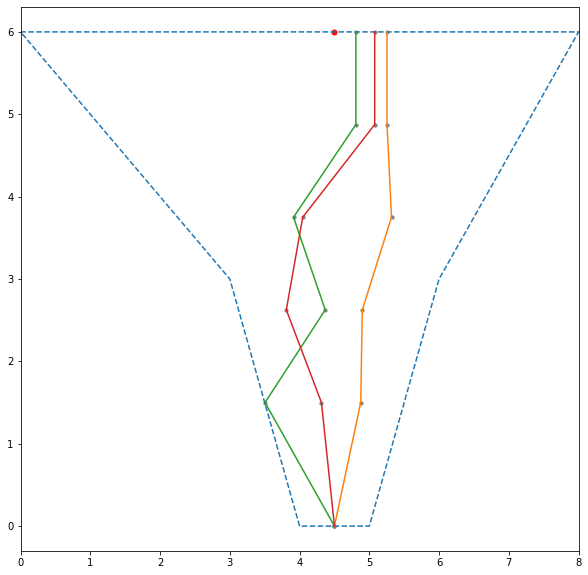

In [38]:
# Plot polygons and points

plt.rcParams["figure.figsize"] = (10,10)
x,y = crosswalk.exterior.xy
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=25, color='red')

for i in range(3):
    line_x = []
    line_y = []

    new_points = shiftedPoints(start, end, crosswalk, destinationLine, d=1.5)
    print("visualization:")

    for i in range(len(new_points)):
        line_x.append(new_points[i].x)
        line_y.append(new_points[i].y)
        print(new_points[i])
        plt.scatter(new_points[i].x, new_points[i].y, s=10, color='grey')

    plt.plot(line_x, line_y)
plt.xlim(0, 8)
plt.savefig('trial.png')